In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os 
from nilearn import plotting
from brainiak.searchlight.searchlight import Searchlight
from scipy.stats import pearsonr
import numpy.ma as ma
%matplotlib inline

### get paths to fmri data, must be 4-d

In [2]:
DATA_DIR = "/media/yoel/second_ssd/neu502b/movie_nii"
FILES = [os.path.join(DATA_DIR, x) for x in os.listdir(DATA_DIR) if x.endswith(".nii")]
FILES

['/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s1.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s10.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s11.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s12.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s13.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s14.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s15.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s16.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s17.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s2.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s3.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s4.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s5.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_movie_s6.nii',
 '/media/yoel/second_ssd/neu502b/movie_nii/sherlock_mo

### get paths to the mask

In [3]:
MASK_PATH = "/media/yoel/second_ssd/neu502b/reqs/3mm_mask.nii.gz"

### load in data

In [4]:
mask_obj = nib.load(MASK_PATH)
bold_obj = nib.load(FILES[0])

### define other variables for the searchlight as shown in the brainiak tutorial

In [5]:
sl_rad = 3 # searchlight radius
max_blk_edge = 6 # not sure 
pool_size = 1 # not sure
dmask = np.array(mask_obj.dataobj).astype(int)
hdata = np.array(bold_obj.dataobj)

# get activations correlation matrix
NNCOR_DIR = "/media/yoel/second_ssd/neu502b/results/nncormats"
NNCOR_FILES = [os.path.join(NNCOR_DIR, x) for x in os.listdir(NNCOR_DIR) if x.endswith(".npy")]
bcvar = np.load(NNCOR_FILES[-1])

In [6]:
# truncate the data to part2
data = hdata[:, :, :, 946:]
mask = dmask

In [7]:
# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad, max_blk_edge=max_blk_edge)

In [8]:
sl.distribute([data], mask)
sl.broadcast(bcvar)

In [18]:
def rsa(data, mask, sl_rad, bcvar): 
    data4D = data[0]
    bolddata_sl = data4D[mask.astype(bool), :].T  
    #bolddata_sl[bolddata_sl == 0] = np.NaN
    human = np.corrcoef(bolddata_sl)
    alexnet = bcvar
    hvec = human[np.triu(np.ones(human.shape)).astype(bool)]
    avec = alexnet[np.triu(np.ones(alexnet.shape)).astype(bool)]
    # masking to ignore infs or nans, i.e. non-brain locations
    hvec_mask = ma.masked_invalid(hvec).mask
    if len(hvec[~hvec_mask]) == 0:
        return 0.0
    return pearsonr(hvec[~hvec_mask], avec[~hvec_mask])[0]

In [19]:
sl_result = sl.run_searchlight(rsa, pool_size=pool_size)

/media/yoel/second_ssd/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [20]:
sl_result[sl_result == None] = 0

In [21]:
ss=np.array(sl_result, dtype=float)

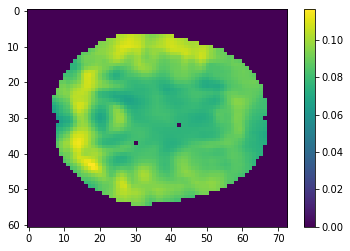

In [41]:
plt.imshow(ss[:, :, 30])
plt.colorbar()

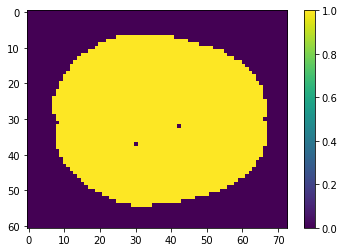

In [42]:
plt.imshow(mask[:, :, 30])
plt.colorbar()